In [4]:
import spacy

nlp = spacy.load('en_core_web_lg')

In [73]:
# load top_words.txt and get the lemma for them in a map
# top words from: https://www.ef.edu/english-resources/english-vocabulary/top-3000-words/
all_clues = []
with open('top_words.txt', 'r') as f:
    for line in f:
        token = line.strip()
        lemma = nlp(token)
        if lemma.has_vector:
            all_clues.append(lemma)

In [74]:

print("Enter two space-separated words")
words = 'cat dog'

tokens = nlp(words)

for token in tokens:
    # Printing the following attributes of each token.
    # text: the word string, has_vector: if it contains
    # a vector representation in the model, 
    # vector_norm: the algebraic norm of the vector,
    # is_oov: if the word is out of vocabulary.
    print(token.text, token.has_vector, token.vector_norm, token.is_oov)

token1, token2 = tokens[0], tokens[1]

print("Similarity:", token1.similarity(token2))

Enter two space-separated words
cat True 63.188496 False
dog True 75.254234 False
Similarity: 0.8220816850662231


In [75]:
# 1) cluster the words based on their similarity
# 2) find the centroid of each cluster
# 3) find the closest word to the centroid, and use it as the clue
# 4) we may need to project the words onto a sphere? or do something different
#    because they don't satisfy the triangle inequality

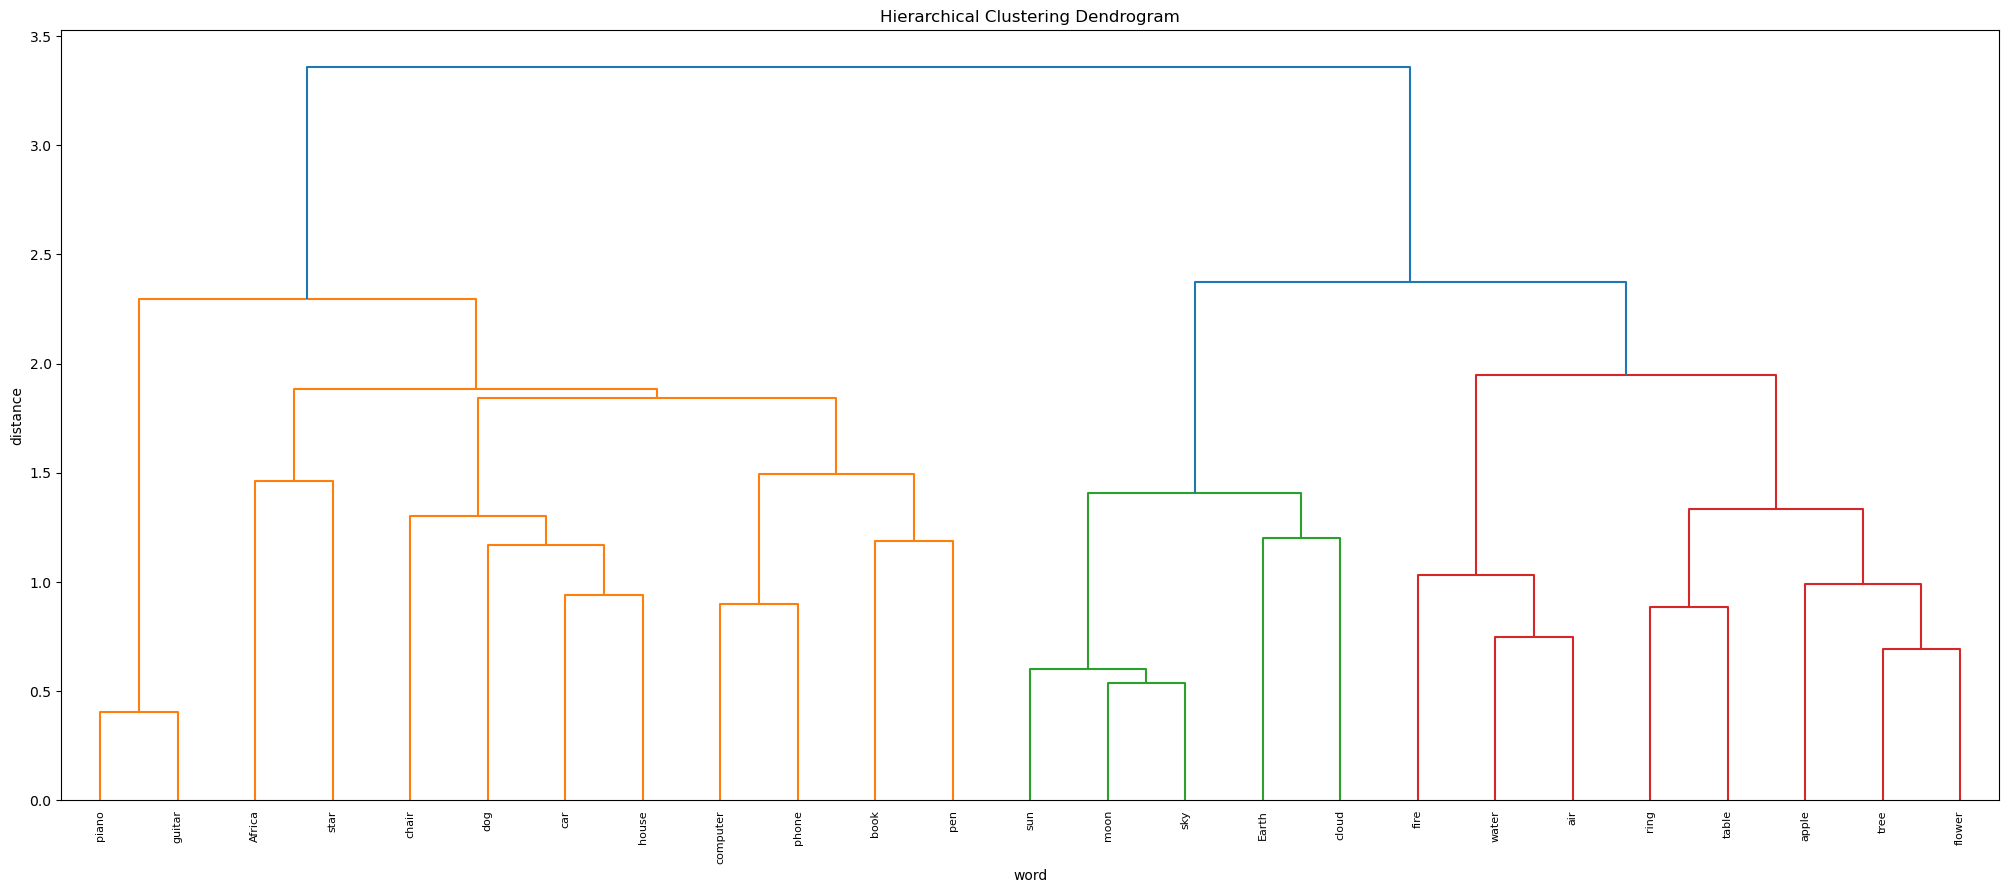

[[ 4.         12.          0.40340319  2.        ]
 [21.         23.          0.53420657  2.        ]
 [20.         26.          0.60129863  3.        ]
 [15.         16.          0.69341495  2.        ]
 [17.         18.          0.74537161  2.        ]
 [ 1.          7.          0.884133    2.        ]
 [10.         11.          0.90064499  2.        ]
 [13.         14.          0.94130219  2.        ]
 [ 5.         28.          0.99012433  3.        ]
 [19.         29.          1.0305172   3.        ]
 [ 2.         32.          1.16658832  3.        ]
 [ 8.          9.          1.18807975  2.        ]
 [ 3.         24.          1.19896669  2.        ]
 [ 6.         35.          1.30375825  4.        ]
 [30.         33.          1.33343436  5.        ]
 [27.         37.          1.4061755   5.        ]
 [ 0.         22.          1.46144647  2.        ]
 [31.         36.          1.49177977  4.        ]
 [38.         42.          1.84200604  8.        ]
 [41.         43.          1.88

In [76]:
# make a list of 25 words
words = ['Africa', 'ring', 'dog', 'Earth', 'piano', 
         'apple', 'chair', 'table', 'book', 'pen', 
         'computer', 'phone', 'guitar', 'car', 'house', 
         'tree', 'flower', 'water', 'air', 'fire', 
         'sun', 'moon', 'star', 'sky', 'cloud']

words = [nlp(word) for word in words]

# cluster the words into groups using scipy
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

import numpy as np
# use the wordA.similarity(wordB) metric
# to get a similarity matrix
similarity_matrix = np.zeros((len(words), len(words)))
for i in range(len(words)):
    for j in range(len(words)):
        similarity_matrix[i, j] = words[i].similarity(words[j])
condensed_similarity_matrix = pdist(similarity_matrix)
# use the similarity matrix to cluster the words
Z = linkage(condensed_similarity_matrix, 'ward')

# plot the dendrogram
import matplotlib.pyplot as plt
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('word')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    labels=[word.text for word in words]
)
plt.show()

print(Z)
print(len(Z))

In [77]:
# print the cluster groups from the linkage Z
# from: https://stackoverflow.com/questions/9838861/scipy-linkage-format
def convert_linkage_to_tree(linkage, words):
    clusters = {}
    for i, merge in enumerate(linkage):
        if merge[0] < len(words):
            # if it is an original point read it from the centers array
            a = words[int(merge[0]) - 1]
        else:
            # other wise read the cluster that has been created
            a = clusters[int(merge[0])]

        if merge[1] < len(words):
            b = words[int(merge[1]) - 1]
        else:
            b = clusters[int(merge[1])]
        # the clusters are 1-indexed by scipy
        clusters[1 + i + len(linkage)] = {
            'children' : [a, b],
            'distance' : merge[2]
        }
        # ^ you could optionally store other info here (e.g distances)
    return clusters



class Leaf(object):
    def __init__(self, word):
        self.lemma = nlp(word)
    
    def __str__(self):
        return self.lemma.text

class Cluster(object):
    def __init__(self, distance, children):
        self.distance = distance
        self.children = children
        self.lemmas = []
    
    def get_lemmas(self):
        # populate the lemmas array if it is empty
        if len(self.lemmas) == 0:
            for child in self.children:
                if isinstance(child, Leaf):
                    self.lemmas.append(child.lemma)
                else:
                    self.lemmas.extend(child.get_lemmas())
        return self.lemmas
    
    def __str__(self):
        return str(self.get_lemmas()) + ' ' + str(np.round(self.distance, 2))


# 1) create a proper tree structure,
#    where each node has the average distance of its children
#    (like shown in the dendrogram) how to do this? TODO
def convert_to_tree(pairs, words):
    leaves = {}
    clusters = {}

    for i, row in enumerate(pairs):
        if row[0] < len(words):
            # if it is an original point read it from the centers array
            a = words[int(row[0])]
            a = Leaf(a)
            leaves[row[0]] = a
        else:
            # other wise read the cluster that has been created
            a = clusters[int(row[0])]

        if row[1] < len(words):
            b = words[int(row[1])]
            b = Leaf(b)
            leaves[row[1]] = b
        else:
            b = clusters[int(row[1])]

        # set a and b as children of the new node
        distance = row[2]
        cluster = Cluster(distance, children=[a, b])

        clusters[1 + i + len(pairs)] = cluster
    return clusters

clusters = convert_to_tree(Z, words)
for key, cluster in clusters.items():
    print(cluster)

[piano, guitar] 0.4
[moon, sky] 0.53
[sun, moon, sky] 0.6
[tree, flower] 0.69
[water, air] 0.75
[ring, table] 0.88
[computer, phone] 0.9
[car, house] 0.94
[apple, tree, flower] 0.99
[fire, water, air] 1.03
[dog, car, house] 1.17
[book, pen] 1.19
[Earth, cloud] 1.2
[chair, dog, car, house] 1.3
[ring, table, apple, tree, flower] 1.33
[sun, moon, sky, Earth, cloud] 1.41
[Africa, star] 1.46
[computer, phone, book, pen] 1.49
[chair, dog, car, house, computer, phone, book, pen] 1.84
[Africa, star, chair, dog, car, house, computer, phone, book, pen] 1.88
[fire, water, air, ring, table, apple, tree, flower] 1.95
[piano, guitar, Africa, star, chair, dog, car, house, computer, phone, book, pen] 2.3
[sun, moon, sky, Earth, cloud, fire, water, air, ring, table, apple, tree, flower] 2.37
[piano, guitar, Africa, star, chair, dog, car, house, computer, phone, book, pen, sun, moon, sky, Earth, cloud, fire, water, air, ring, table, apple, tree, flower] 3.36


0.44662042537636254 1.3324816363933283 0.6682966597076201


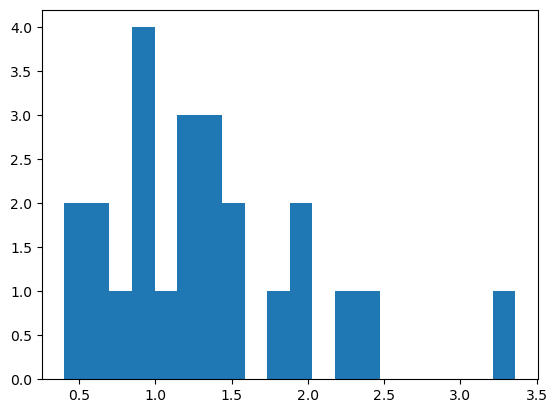

0.4 [piano, guitar] --> musician
0.53 [moon, sky] --> horizon
0.6 [sun, moon, sky] --> horizon
0.69 [tree, flower] --> leaf
0.75 [water, air] --> surface
0.88 [ring, table] --> string
0.9 [computer, phone] --> telephone
0.94 [car, house] --> vehicle
0.99 [apple, tree, flower] --> orange
1.03 [fire, water, air] --> ground
1.17 [dog, car, house] --> garage
1.19 [book, pen] --> reader
1.2 [Earth, cloud] --> planet
1.3 [chair, dog, car, house] --> garage
1.33 [ring, table, apple, tree, flower] --> vegetable
1.41 [sun, moon, sky, Earth, cloud] --> horizon
1.46 [Africa, star] --> celebrity
1.49 [computer, phone, book, pen] --> telephone
1.84 [chair, dog, car, house, computer, phone, book, pen] --> cigarette
1.88 [Africa, star, chair, dog, car, house, computer, phone, book, pen] --> unfortunately
1.95 [fire, water, air, ring, table, apple, tree, flower] --> container
2.3 [piano, guitar, Africa, star, chair, dog, car, house, computer, phone, book, pen] --> stranger
2.37 [sun, moon, sky, Earth,

In [84]:
# 2) find clues for each group, and choose the top clue
#    (by cluster average distance and distance from clue to the center of the cluster)

def get_clue(cluster):
    all_clues_less_cluster = [w for w in all_clues if w.text not in [c.text for c in cluster]]

    # get the average vector for the cluster
    cluster_avg = np.mean([w.vector for w in cluster], axis=0)
    # get the distance from each word to the cluster average
    distances = [np.linalg.norm(w.vector - cluster_avg) for w in all_clues_less_cluster]
    # get the index of the word with the smallest distance
    clue_index = np.argmin(distances)
    # return the word with the smallest distance
    return all_clues_less_cluster[clue_index].text

distances = []
for key, cluster in clusters.items():
    distances.append(cluster.distance)
distances = np.array(distances)
print(np.var(distances), np.mean(distances), np.std(distances))

import matplotlib.pyplot as plt
plt.hist(distances, bins=20)
plt.show()


for key, cluster in clusters.items():
    print(np.round(cluster.distance, 2), cluster.get_lemmas(), '-->', get_clue(cluster.get_lemmas()))